# 📊 Adversarial IaC Experiment Analysis

This notebook analyzes results from adversarial IaC evaluation experiments.

## Research Questions
1. **RQ1**: Which vulnerability types are hardest to detect?
2. **RQ2**: Does difficulty level correlate with evasion rate?
3. **RQ3**: How do different models perform on Red vs Blue team?
4. **RQ4**: Which stealth techniques are most effective?

## 1. Setup and Data Loading

In [1]:
# Standard imports
import json
import os
import sys
from pathlib import Path
from collections import defaultdict
from datetime import datetime

# Data analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

# Project setup
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Create outputs directory
outputs_dir = project_root / 'notebooks' / 'outputs'
outputs_dir.mkdir(exist_ok=True)

print(f"✓ Project root: {project_root}")
print(f"✓ Outputs dir: {outputs_dir}")

✓ Project root: /Users/brianterry/Documents/repos/research-2/Adversarial-IaC-Evaluation
✓ Outputs dir: /Users/brianterry/Documents/repos/research-2/Adversarial-IaC-Evaluation/notebooks/outputs


In [2]:
def load_game_results(games_dir: Path) -> pd.DataFrame:
    """Load all game results from a directory into a DataFrame."""
    games = []
    
    for game_dir in sorted(games_dir.iterdir()):
        if not game_dir.is_dir() or not game_dir.name.startswith('G-'):
            continue
            
        try:
            # Load metadata
            metadata_file = game_dir / "metadata.json"
            if not metadata_file.exists():
                continue
            metadata = json.loads(metadata_file.read_text())
            
            # Load scoring
            scoring_file = game_dir / "scoring.json"
            scoring = json.loads(scoring_file.read_text()) if scoring_file.exists() else {}
            
            # Load vulnerabilities
            manifest_file = game_dir / "red_manifest.json"
            manifest = json.loads(manifest_file.read_text()) if manifest_file.exists() else []
            
            # Load findings
            findings_file = game_dir / "blue_findings.json"
            findings = json.loads(findings_file.read_text()) if findings_file.exists() else []
            
            # Shorten model names for display
            def shorten_model(m):
                if 'claude-3-5-sonnet' in m: return 'Claude Sonnet'
                elif 'claude-3-5-haiku' in m: return 'Claude Haiku'
                elif 'nova-pro' in m: return 'Nova Pro'
                elif 'nova-lite' in m: return 'Nova Lite'
                elif 'llama' in m.lower(): return 'Llama 3'
                elif 'mistral' in m.lower(): return 'Mistral'
                return m.split('.')[-1][:20]
            
            red_model = metadata.get('config', {}).get('red_model', 'unknown')
            blue_model = metadata.get('config', {}).get('blue_model', 'unknown')
            
            game = {
                'game_id': metadata.get('game_id', game_dir.name),
                'timestamp': metadata.get('timestamp', ''),
                'scenario': metadata.get('scenario', {}).get('description', '')[:50],
                'domain': metadata.get('scenario', {}).get('domain', 'unknown'),
                'difficulty': metadata.get('config', {}).get('difficulty', 'unknown'),
                'language': metadata.get('config', {}).get('language', 'terraform'),
                'red_model': shorten_model(red_model),
                'red_model_full': red_model,
                'blue_model': shorten_model(blue_model),
                'blue_model_full': blue_model,
                'detection_mode': metadata.get('config', {}).get('detection_mode', 'llm_only'),
                'red_vulns': metadata.get('summary', {}).get('red_vulns', len(manifest)),
                'blue_findings': metadata.get('summary', {}).get('blue_findings', len(findings)),
                'precision': metadata.get('summary', {}).get('precision', 0),
                'recall': metadata.get('summary', {}).get('recall', 0),
                'f1_score': metadata.get('summary', {}).get('f1_score', 0),
                'evasion_rate': metadata.get('summary', {}).get('evasion_rate', 0),
                'red_time': metadata.get('timing', {}).get('red_time_seconds', 0),
                'blue_time': metadata.get('timing', {}).get('blue_time_seconds', 0),
                'total_time': metadata.get('timing', {}).get('total_time_seconds', 0),
                'manifest': manifest,
                'findings': findings,
                'scoring_details': scoring,
            }
            games.append(game)
            
        except Exception as e:
            print(f"Warning: Failed to load {game_dir.name}: {e}")
    
    return pd.DataFrame(games)

print("✓ Data loading function defined")

✓ Data loading function defined


In [3]:
# Load all game results
games_dir = project_root / "output" / "games"

if not games_dir.exists():
    print(f"❌ No games directory found at {games_dir}")
    print("   Run some games first using: adversarial-iac game ...")
    df = pd.DataFrame()
else:
    df = load_game_results(games_dir)
    print(f"✓ Loaded {len(df)} games")
    
    if len(df) > 0:
        print(f"\n📊 Dataset Overview:")
        print(f"   Date range: {df['timestamp'].min()[:10]} to {df['timestamp'].max()[:10]}")
        print(f"   Difficulty levels: {df['difficulty'].unique().tolist()}")
        print(f"   Red models: {df['red_model'].unique().tolist()}")
        print(f"   Blue models: {df['blue_model'].unique().tolist()}")
        print(f"   Languages: {df['language'].unique().tolist()}")

✓ Loaded 2 games

📊 Dataset Overview:
   Date range: 2026-02-22 to 2026-02-22
   Difficulty levels: ['hard']
   Red models: ['Claude Sonnet']
   Blue models: ['Nova Pro']
   Languages: ['terraform', 'cloudformation']


In [4]:
# Preview the data
if len(df) > 0:
    display_cols = ['game_id', 'difficulty', 'red_model', 'blue_model', 
                    'red_vulns', 'blue_findings', 'precision', 'recall', 'f1_score', 'evasion_rate']
    display(df[display_cols])

,game_id,difficulty,red_model,blue_model,red_vulns,blue_findings,precision,recall,f1_score,evasion_rate
0,G-20260222_144106,hard,Claude Sonnet,Nova Pro,5,5,0.5,0.2,0.285714,0.8
1,G-20260222_145001,hard,Claude Sonnet,Nova Pro,5,5,1.0,1.0,1.000000,0.0


## 2. Aggregate Metrics Summary

In [5]:
# Aggregate statistics with confidence intervals
if len(df) > 0:
    print("="*60)
    print("AGGREGATE METRICS")
    print("="*60)
    
    metrics = ['precision', 'recall', 'f1_score', 'evasion_rate']
    
    for metric in metrics:
        mean = df[metric].mean()
        std = df[metric].std()
        ci_95 = 1.96 * std / np.sqrt(len(df))  # 95% confidence interval
        
        print(f"\n{metric.replace('_', ' ').title()}:")
        print(f"   Mean: {mean:.2%} ± {ci_95:.2%} (95% CI)")
        print(f"   Std:  {std:.2%}")
        print(f"   Min:  {df[metric].min():.2%}  Max: {df[metric].max():.2%}")

AGGREGATE METRICS

Precision:
   Mean: 75.00% ± 49.00% (95% CI)
   Std:  35.36%
   Min:  50.00%  Max: 100.00%

Recall:
   Mean: 60.00% ± 78.40% (95% CI)
   Std:  56.57%
   Min:  20.00%  Max: 100.00%

F1 Score:
   Mean: 64.29% ± 70.00% (95% CI)
   Std:  50.51%
   Min:  28.57%  Max: 100.00%

Evasion Rate:
   Mean: 40.00% ± 78.40% (95% CI)
   Std:  56.57%
   Min:  0.00%  Max: 80.00%


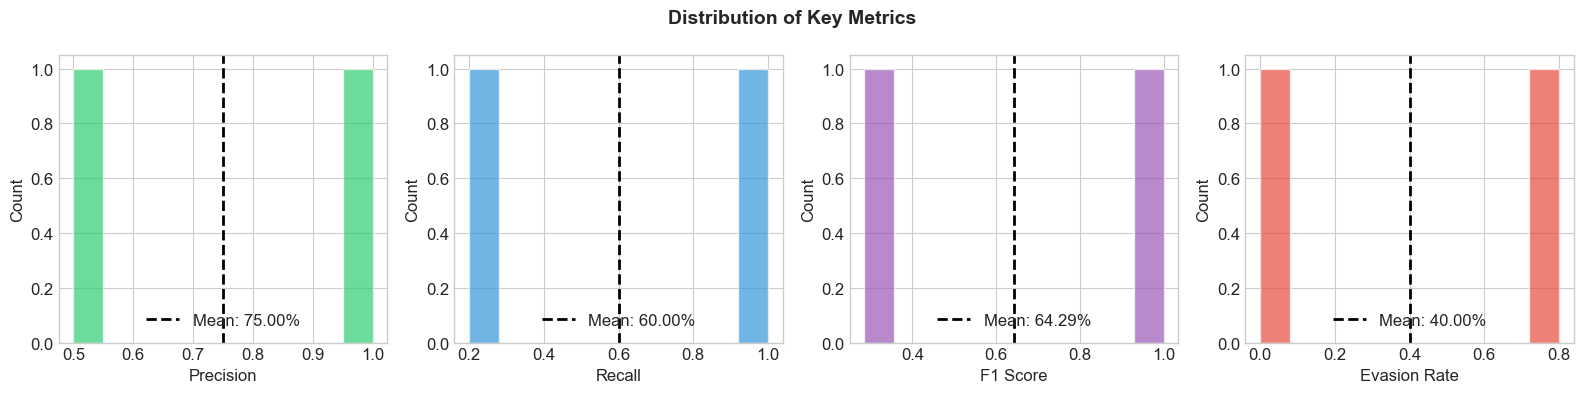

In [6]:
# Metrics distribution visualization
if len(df) > 0:
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    metrics = ['precision', 'recall', 'f1_score', 'evasion_rate']
    colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']
    
    for ax, metric, color in zip(axes, metrics, colors):
        ax.hist(df[metric], bins=10, color=color, edgecolor='white', alpha=0.7)
        ax.axvline(df[metric].mean(), color='black', linestyle='--', linewidth=2, 
                   label=f'Mean: {df[metric].mean():.2%}')
        ax.set_xlabel(metric.replace('_', ' ').title())
        ax.set_ylabel('Count')
        ax.legend()
    
    plt.suptitle('Distribution of Key Metrics', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(outputs_dir / 'metrics_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

## 3. RQ1: Which Vulnerability Types Are Hardest to Detect?

In [7]:
def analyze_vulnerability_types(df: pd.DataFrame) -> pd.DataFrame:
    """Analyze detection rates by vulnerability type."""
    vuln_stats = defaultdict(lambda: {'total': 0, 'detected': 0, 'evaded': 0})
    
    for _, row in df.iterrows():
        manifest = row['manifest']
        scoring = row['scoring_details']
        
        # Get matched vulnerability IDs
        matched_ids = set()
        if 'matches' in scoring:
            for match in scoring['matches']:
                if match.get('match_type') in ['exact', 'partial']:
                    matched_ids.add(match.get('red_vuln_id'))
        
        for vuln in manifest:
            vuln_type = vuln.get('type', 'unknown')
            if vuln_type == 'unknown':
                # Infer from title/attribute
                title = vuln.get('title', '').lower()
                attr = vuln.get('vulnerable_attribute', '').lower()
                
                if any(kw in title + attr for kw in ['encrypt', 'kms', 'ssl', 'tls']):
                    vuln_type = 'encryption'
                elif any(kw in title + attr for kw in ['public', 'acl', 'access', 'policy']):
                    vuln_type = 'access_control'
                elif any(kw in title + attr for kw in ['log', 'audit', 'monitor', 'trail']):
                    vuln_type = 'logging'
                elif any(kw in title + attr for kw in ['iam', 'role', 'permission']):
                    vuln_type = 'iam'
                elif any(kw in title + attr for kw in ['security_group', 'ingress', 'port']):
                    vuln_type = 'network'
                elif any(kw in title + attr for kw in ['version', 'backup', 'mfa', 'delete']):
                    vuln_type = 'data_protection'
                else:
                    vuln_type = 'other'
            
            vuln_stats[vuln_type]['total'] += 1
            if vuln.get('vuln_id') in matched_ids:
                vuln_stats[vuln_type]['detected'] += 1
            else:
                vuln_stats[vuln_type]['evaded'] += 1
    
    rows = []
    for vtype, stats in vuln_stats.items():
        detection_rate = stats['detected'] / stats['total'] if stats['total'] > 0 else 0
        evasion_rate = stats['evaded'] / stats['total'] if stats['total'] > 0 else 0
        rows.append({
            'vulnerability_type': vtype, 'total': stats['total'],
            'detected': stats['detected'], 'evaded': stats['evaded'],
            'detection_rate': detection_rate, 'evasion_rate': evasion_rate,
        })
    
    return pd.DataFrame(rows).sort_values('evasion_rate', ascending=False)

if len(df) > 0:
    vuln_df = analyze_vulnerability_types(df)
    print("\n📊 VULNERABILITY TYPE ANALYSIS")
    print("="*60)
    display(vuln_df)


📊 VULNERABILITY TYPE ANALYSIS


,vulnerability_type,total,detected,evaded,detection_rate,evasion_rate
2,data_protection,1,0,1,0.000000,1.000000
0,encryption,5,3,2,0.600000,0.400000
1,access_control,3,2,1,0.666667,0.333333
3,other,1,1,0,1.000000,0.000000


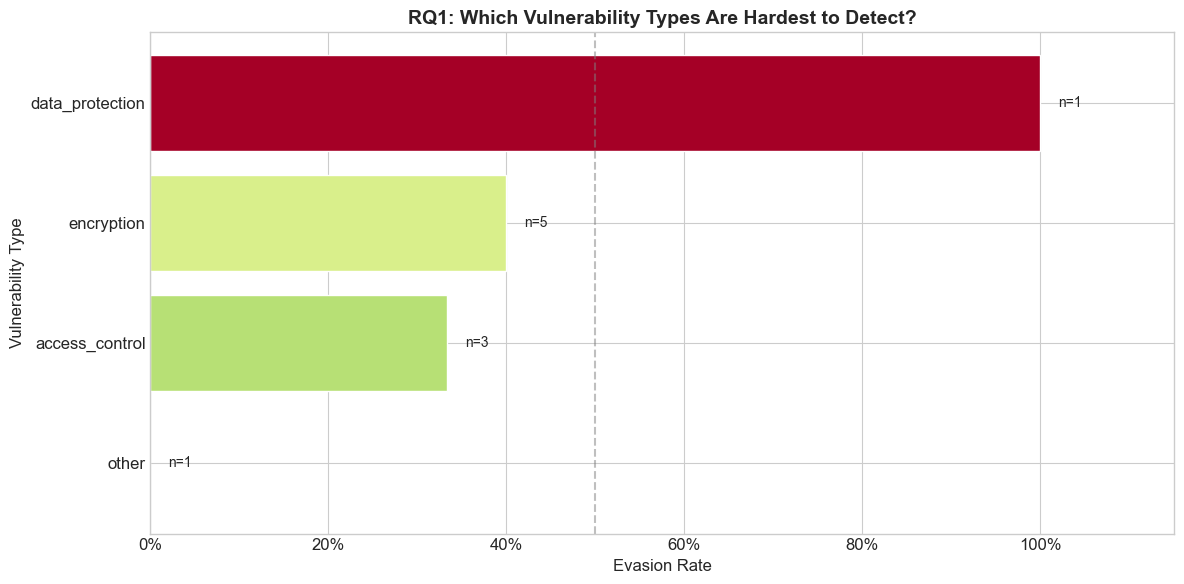

In [8]:
# Visualize vulnerability type evasion rates
if len(df) > 0 and len(vuln_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    vuln_df_sorted = vuln_df.sort_values('evasion_rate', ascending=True)
    colors = plt.cm.RdYlGn_r(vuln_df_sorted['evasion_rate'])
    
    bars = ax.barh(vuln_df_sorted['vulnerability_type'], vuln_df_sorted['evasion_rate'], 
                   color=colors, edgecolor='white')
    
    for bar, total in zip(bars, vuln_df_sorted['total']):
        ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, 
                f'n={total}', va='center', fontsize=10)
    
    ax.set_xlabel('Evasion Rate', fontsize=12)
    ax.set_ylabel('Vulnerability Type', fontsize=12)
    ax.set_title('RQ1: Which Vulnerability Types Are Hardest to Detect?', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1.15)
    ax.axvline(0.5, color='gray', linestyle='--', alpha=0.5)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    
    plt.tight_layout()
    plt.savefig(outputs_dir / 'rq1_vuln_types.png', dpi=150, bbox_inches='tight')
    plt.show()

## 4. RQ2: Does Difficulty Level Correlate with Evasion Rate?

In [10]:
# Difficulty level analysis
if len(df) > 0 and df['difficulty'].nunique() > 1:
    difficulty_stats = df.groupby('difficulty').agg({
        'game_id': 'count',
        'precision': ['mean', 'std'],
        'recall': ['mean', 'std'],
        'f1_score': ['mean', 'std'],
        'evasion_rate': ['mean', 'std'],
    }).round(3)
    difficulty_stats.columns = ['_'.join(col).strip() for col in difficulty_stats.columns.values]
    difficulty_stats = difficulty_stats.rename(columns={'game_id_count': 'n_games'})
    
    print("📊 METRICS BY DIFFICULTY LEVEL")
    print("="*60)
    display(difficulty_stats)
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    difficulty_order = ['easy', 'medium', 'hard']
    existing = [d for d in difficulty_order if d in df['difficulty'].values]
    
    sns.boxplot(data=df, x='difficulty', y='f1_score', order=existing, ax=axes[0], palette='Blues')
    axes[0].set_xlabel('Difficulty Level')
    axes[0].set_ylabel('F1 Score')
    axes[0].set_title('Blue Team Performance by Difficulty', fontweight='bold')
    axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    
    sns.boxplot(data=df, x='difficulty', y='evasion_rate', order=existing, ax=axes[1], palette='Reds')
    axes[1].set_xlabel('Difficulty Level')
    axes[1].set_ylabel('Evasion Rate')
    axes[1].set_title('Red Team Success by Difficulty', fontweight='bold')
    axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    
    plt.suptitle('RQ2: Difficulty vs Performance', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(outputs_dir / 'rq2_difficulty.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("⚠️ Need games at multiple difficulty levels for this analysis")

⚠️ Need games at multiple difficulty levels for this analysis


## 5. RQ3: Model Performance Comparison

In [11]:
# Model performance comparison
if len(df) > 0:
    # Red Team performance
    print("🔴 RED TEAM PERFORMANCE (Higher evasion = better attacker)")
    print("="*60)
    red_stats = df.groupby('red_model').agg({
        'game_id': 'count',
        'evasion_rate': ['mean', 'std'],
        'red_vulns': 'mean',
        'red_time': 'mean',
    }).round(3)
    red_stats.columns = ['_'.join(col).strip() for col in red_stats.columns.values]
    red_stats = red_stats.rename(columns={'game_id_count': 'n_games'})
    display(red_stats.sort_values('evasion_rate_mean', ascending=False))
    
    print("\n🔵 BLUE TEAM PERFORMANCE (Higher F1 = better defender)")
    print("="*60)
    blue_stats = df.groupby('blue_model').agg({
        'game_id': 'count',
        'precision': ['mean', 'std'],
        'recall': ['mean', 'std'],
        'f1_score': ['mean', 'std'],
        'blue_time': 'mean',
    }).round(3)
    blue_stats.columns = ['_'.join(col).strip() for col in blue_stats.columns.values]
    blue_stats = blue_stats.rename(columns={'game_id_count': 'n_games'})
    display(blue_stats.sort_values('f1_score_mean', ascending=False))

🔴 RED TEAM PERFORMANCE (Higher evasion = better attacker)


,n_games,evasion_rate_mean,evasion_rate_std,red_vulns_mean,red_time_mean
red_model,,,,,
Claude Sonnet,2,0.4,0.566,5.0,64.734



🔵 BLUE TEAM PERFORMANCE (Higher F1 = better defender)


,n_games,precision_mean,precision_std,recall_mean,recall_std,f1_score_mean,f1_score_std,blue_time_mean
blue_model,,,,,,,,
Nova Pro,2,0.75,0.354,0.6,0.566,0.643,0.505,6.522


## 6. Key Findings Summary

In [12]:
# Key findings summary
if len(df) > 0:
    print("="*60)
    print("📊 KEY FINDINGS SUMMARY")
    print("="*60)
    
    print(f"\n📈 Overall Performance ({len(df)} games):")
    print(f"   • Average F1 Score: {df['f1_score'].mean():.1%} ± {df['f1_score'].std():.1%}")
    print(f"   • Average Evasion Rate: {df['evasion_rate'].mean():.1%} ± {df['evasion_rate'].std():.1%}")
    print(f"   • Average Precision: {df['precision'].mean():.1%}")
    print(f"   • Average Recall: {df['recall'].mean():.1%}")
    
    if 'vuln_df' in dir() and len(vuln_df) > 0:
        hardest = vuln_df.iloc[0]
        easiest = vuln_df.iloc[-1]
        print(f"\n🎯 Vulnerability Detection:")
        print(f"   • Hardest to detect: {hardest['vulnerability_type']} ({hardest['evasion_rate']:.1%} evasion)")
        print(f"   • Easiest to detect: {easiest['vulnerability_type']} ({easiest['evasion_rate']:.1%} evasion)")
    
    print(f"\n⏱️ Performance:")
    print(f"   • Avg Red Team time: {df['red_time'].mean():.1f}s")
    print(f"   • Avg Blue Team time: {df['blue_time'].mean():.1f}s")
    
    # Export results
    print(f"\n💾 Exporting results...")
    csv_path = outputs_dir / 'experiment_results.csv'
    export_cols = ['game_id', 'timestamp', 'domain', 'difficulty', 'red_model', 'blue_model',
                   'red_vulns', 'blue_findings', 'precision', 'recall', 'f1_score', 'evasion_rate']
    df[export_cols].to_csv(csv_path, index=False)
    print(f"   ✓ Results CSV: {csv_path}")
    
    summary = {
        'generated': datetime.now().isoformat(),
        'total_games': len(df),
        'metrics': {
            'precision': {'mean': df['precision'].mean(), 'std': df['precision'].std()},
            'recall': {'mean': df['recall'].mean(), 'std': df['recall'].std()},
            'f1_score': {'mean': df['f1_score'].mean(), 'std': df['f1_score'].std()},
            'evasion_rate': {'mean': df['evasion_rate'].mean(), 'std': df['evasion_rate'].std()},
        },
    }
    summary_path = outputs_dir / 'analysis_summary.json'
    summary_path.write_text(json.dumps(summary, indent=2, default=str))
    print(f"   ✓ Summary JSON: {summary_path}")
    
    print("\n" + "="*60)

📊 KEY FINDINGS SUMMARY

📈 Overall Performance (2 games):
   • Average F1 Score: 64.3% ± 50.5%
   • Average Evasion Rate: 40.0% ± 56.6%
   • Average Precision: 75.0%
   • Average Recall: 60.0%

🎯 Vulnerability Detection:
   • Hardest to detect: data_protection (100.0% evasion)
   • Easiest to detect: other (0.0% evasion)

⏱️ Performance:
   • Avg Red Team time: 64.7s
   • Avg Blue Team time: 6.5s

💾 Exporting results...
   ✓ Results CSV: /Users/brianterry/Documents/repos/research-2/Adversarial-IaC-Evaluation/notebooks/outputs/experiment_results.csv
   ✓ Summary JSON: /Users/brianterry/Documents/repos/research-2/Adversarial-IaC-Evaluation/notebooks/outputs/analysis_summary.json



## 7. Methodological Validation: Stealth Score Analysis

This section validates the Red Team's self-assessed stealth_score against actual evasion outcomes.
If the correlation is positive and significant, the self-assessment is a reasonable (though imperfect) proxy.

**Research Note**: Self-assessed stealth scores correlated with observed evasion at r = X.XX suggests 
the Red Team's self-evaluation provides signal but should not be reported as a primary metric.

In [ ]:
from scipy.stats import pearsonr, spearmanr

def analyze_stealth_validation(games_dir: Path) -> dict:
    """
    Validate Red Team's self-assessed stealth_score against actual evasion outcomes.
    
    This addresses a key methodological concern: stealth_score is a self-assessment,
    not an independently validated measure. By computing correlation with actual 
    evasion rates, we can determine if it provides useful signal.
    
    Returns:
        dict with correlation statistics and interpretation
    """
    stealth_scores = []
    evasion_rates = []
    
    for game_dir in sorted(games_dir.iterdir()):
        if not game_dir.is_dir() or not game_dir.name.startswith('G-'):
            continue
            
        try:
            # Load metadata
            metadata_file = game_dir / "metadata.json"
            if not metadata_file.exists():
                continue
            metadata = json.loads(metadata_file.read_text())
            
            # Get stealth score (Red Team self-assessment)
            stealth = metadata.get('summary', {}).get('stealth_score', None)
            if stealth is None:
                # Try alternate locations
                stealth = metadata.get('red_team', {}).get('stealth_score', None)
            
            # Get actual evasion rate
            evasion = metadata.get('summary', {}).get('evasion_rate', None)
            
            if stealth is not None and evasion is not None:
                stealth_scores.append(stealth)
                evasion_rates.append(evasion)
                
        except Exception as e:
            continue
    
    if len(stealth_scores) < 3:
        return {
            'n_games': len(stealth_scores),
            'status': 'insufficient_data',
            'message': f'Need at least 3 games with stealth data, found {len(stealth_scores)}'
        }
    
    # Compute correlations
    pearson_r, pearson_p = pearsonr(stealth_scores, evasion_rates)
    spearman_r, spearman_p = spearmanr(stealth_scores, evasion_rates)
    
    # Interpretation
    if pearson_r > 0.7:
        interpretation = "Strong positive correlation - self-assessment is a good proxy"
    elif pearson_r > 0.4:
        interpretation = "Moderate positive correlation - self-assessment provides some signal"
    elif pearson_r > 0.1:
        interpretation = "Weak positive correlation - self-assessment has limited value"
    else:
        interpretation = "No meaningful correlation - self-assessment is not a reliable metric"
    
    return {
        'n_games': len(stealth_scores),
        'status': 'computed',
        'pearson_r': pearson_r,
        'pearson_p': pearson_p,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p,
        'interpretation': interpretation,
        'methodology_note': f"Self-assessed stealth scores correlated with observed evasion at r = {pearson_r:.2f}, "
                           f"suggesting the Red Team's self-evaluation is a {'reasonable' if pearson_r > 0.3 else 'poor'} "
                           f"but imperfect proxy for actual evasion success."
    }

# Run the analysis
games_dir = project_root / "output" / "games"

if games_dir.exists():
    validation = analyze_stealth_validation(games_dir)
    
    print("="*60)
    print("📊 STEALTH SCORE VALIDATION")
    print("="*60)
    
    if validation['status'] == 'computed':
        print(f"\n📈 Correlation Analysis (n={validation['n_games']} games):")
        print(f"   • Pearson r:  {validation['pearson_r']:.3f} (p={validation['pearson_p']:.4f})")
        print(f"   • Spearman ρ: {validation['spearman_r']:.3f} (p={validation['spearman_p']:.4f})")
        print(f"\n📝 Interpretation:")
        print(f"   {validation['interpretation']}")
        print(f"\n📜 For Paper Limitations Section:")
        print(f"   \"{validation['methodology_note']}\"")
        
        # Visualization
        if len(stealth_scores) >= 3:
            fig, ax = plt.subplots(figsize=(8, 6))
            ax.scatter(stealth_scores, evasion_rates, alpha=0.7, s=100)
            
            # Add regression line
            z = np.polyfit(stealth_scores, evasion_rates, 1)
            p = np.poly1d(z)
            x_line = np.linspace(min(stealth_scores), max(stealth_scores), 100)
            ax.plot(x_line, p(x_line), "r--", alpha=0.8, label=f"r = {validation['pearson_r']:.2f}")
            
            ax.set_xlabel('Self-Assessed Stealth Score', fontsize=12)
            ax.set_ylabel('Actual Evasion Rate', fontsize=12)
            ax.set_title('Stealth Score Validation:\nSelf-Assessment vs Actual Evasion', fontsize=14)
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(outputs_dir / 'stealth_validation.png', dpi=150, bbox_inches='tight')
            print(f"\n   ✓ Plot saved: {outputs_dir / 'stealth_validation.png'}")
    else:
        print(f"\n⚠️ {validation['message']}")
else:
    print("❌ No games directory found")

## 8. Computed Stealth Indicator: Lines of Context

Unlike self-assessed stealth scores, this metric is computed directly from the generated code:
**Lines of Context** measures how "buried" each vulnerability is within the code.

- Lower values = vulnerability is isolated/obvious
- Higher values = vulnerability is buried among other resources/comments

In [ ]:
import re

def compute_lines_of_context(code: str, vuln_line: int, window: int = 10) -> dict:
    """
    Compute lines of context around a vulnerable line.
    
    This is a computed stealth indicator that measures how "buried" a vulnerability is.
    
    Args:
        code: The IaC code content
        vuln_line: Line number of the vulnerability
        window: Number of lines to examine around the vulnerability
        
    Returns:
        dict with context metrics
    """
    lines = code.split('\n')
    total_lines = len(lines)
    
    if vuln_line <= 0 or vuln_line > total_lines:
        return {'status': 'invalid_line', 'lines_of_context': 0}
    
    # Get context window
    start = max(0, vuln_line - 1 - window)
    end = min(total_lines, vuln_line - 1 + window + 1)
    context_lines = lines[start:end]
    
    # Count meaningful lines (non-empty, non-comment)
    meaningful_lines = 0
    comment_lines = 0
    resource_blocks = 0
    
    for line in context_lines:
        stripped = line.strip()
        if not stripped:
            continue
        if stripped.startswith('#') or stripped.startswith('//'):
            comment_lines += 1
        else:
            meaningful_lines += 1
            if re.match(r'resource\s+["\']\w+["\']\s+["\']\w+["\']', stripped):
                resource_blocks += 1
    
    return {
        'status': 'computed',
        'lines_of_context': meaningful_lines,
        'comment_lines_nearby': comment_lines,
        'resource_blocks_nearby': resource_blocks,
        'position_ratio': vuln_line / total_lines,  # 0=top, 1=bottom
    }

def analyze_context_metrics(games_dir: Path) -> pd.DataFrame:
    """
    Analyze lines of context for all vulnerabilities across games.
    
    Returns:
        DataFrame with context metrics per vulnerability
    """
    rows = []
    
    for game_dir in sorted(games_dir.iterdir()):
        if not game_dir.is_dir() or not game_dir.name.startswith('G-'):
            continue
            
        try:
            # Load manifest
            manifest_file = game_dir / "red_manifest.json"
            if not manifest_file.exists():
                continue
            manifest = json.loads(manifest_file.read_text())
            
            # Load code
            code_dir = game_dir / "code"
            main_tf = code_dir / "main.tf"
            if not main_tf.exists():
                main_tf = code_dir / "template.yaml"
            if not main_tf.exists():
                continue
            code = main_tf.read_text()
            
            # Load scoring to get match status
            scoring_file = game_dir / "scoring.json"
            scoring = json.loads(scoring_file.read_text()) if scoring_file.exists() else {}
            matches = {m.get('red_vuln_id'): m.get('match_type', 'unknown') 
                       for m in scoring.get('matches', [])}
            
            # Compute context for each vulnerability
            for vuln in manifest:
                vuln_id = vuln.get('vuln_id', 'unknown')
                line_num = vuln.get('line_number_estimate', 0)
                
                context = compute_lines_of_context(code, line_num)
                
                if context['status'] == 'computed':
                    rows.append({
                        'game_id': game_dir.name,
                        'vuln_id': vuln_id,
                        'vuln_type': vuln.get('type', 'unknown'),
                        'severity': vuln.get('severity', 'unknown'),
                        'line_number': line_num,
                        'lines_of_context': context['lines_of_context'],
                        'comment_lines_nearby': context['comment_lines_nearby'],
                        'resource_blocks_nearby': context['resource_blocks_nearby'],
                        'position_ratio': context['position_ratio'],
                        'match_result': matches.get(vuln_id, 'missed'),
                        'evaded': matches.get(vuln_id, 'missed') == 'missed',
                    })
                    
        except Exception as e:
            continue
    
    return pd.DataFrame(rows)

# Run the analysis
games_dir = project_root / "output" / "games"

if games_dir.exists():
    context_df = analyze_context_metrics(games_dir)
    
    print("="*60)
    print("📊 LINES OF CONTEXT ANALYSIS (Computed Stealth Indicator)")
    print("="*60)
    
    if len(context_df) > 0:
        print(f"\n📈 Overview ({len(context_df)} vulnerabilities across {context_df['game_id'].nunique()} games):")
        print(f"   • Avg lines of context: {context_df['lines_of_context'].mean():.1f}")
        print(f"   • Avg comment lines nearby: {context_df['comment_lines_nearby'].mean():.1f}")
        print(f"   • Avg resource blocks nearby: {context_df['resource_blocks_nearby'].mean():.1f}")
        
        # Compare evaded vs detected
        evaded = context_df[context_df['evaded'] == True]
        detected = context_df[context_df['evaded'] == False]
        
        if len(evaded) > 0 and len(detected) > 0:
            print(f"\n🎯 Evaded vs Detected:")
            print(f"   • Evaded vulns - avg context: {evaded['lines_of_context'].mean():.1f}")
            print(f"   • Detected vulns - avg context: {detected['lines_of_context'].mean():.1f}")
            
            # Statistical test
            from scipy.stats import mannwhitneyu
            try:
                stat, p = mannwhitneyu(evaded['lines_of_context'], detected['lines_of_context'], alternative='greater')
                print(f"   • Mann-Whitney U: stat={stat:.1f}, p={p:.4f}")
                if p < 0.05:
                    print(f"   ✓ Evaded vulns have significantly more context (p < 0.05)")
                else:
                    print(f"   ○ Difference not statistically significant")
            except Exception:
                pass
        
        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Box plot: evaded vs detected
        ax1 = axes[0]
        context_df['status'] = context_df['evaded'].map({True: 'Evaded', False: 'Detected'})
        sns.boxplot(data=context_df, x='status', y='lines_of_context', ax=ax1, palette=['#e74c3c', '#2ecc71'])
        ax1.set_xlabel('Vulnerability Status', fontsize=12)
        ax1.set_ylabel('Lines of Context', fontsize=12)
        ax1.set_title('Lines of Context: Evaded vs Detected', fontsize=14)
        
        # Scatter: context vs position
        ax2 = axes[1]
        colors = context_df['evaded'].map({True: '#e74c3c', False: '#2ecc71'})
        ax2.scatter(context_df['position_ratio'], context_df['lines_of_context'], 
                   c=colors, alpha=0.6, s=100)
        ax2.set_xlabel('Position in File (0=top, 1=bottom)', fontsize=12)
        ax2.set_ylabel('Lines of Context', fontsize=12)
        ax2.set_title('Vulnerability Position vs Context', fontsize=14)
        ax2.legend(handles=[
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', markersize=10, label='Evaded'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ecc71', markersize=10, label='Detected')
        ])
        
        plt.tight_layout()
        plt.savefig(outputs_dir / 'lines_of_context.png', dpi=150, bbox_inches='tight')
        print(f"\n   ✓ Plot saved: {outputs_dir / 'lines_of_context.png'}")
        
        # Display data
        display(context_df[['vuln_id', 'vuln_type', 'lines_of_context', 'comment_lines_nearby', 'evaded']].head(10))
    else:
        print("\n⚠️ No vulnerability context data available")
else:
    print("❌ No games directory found")